# 한성대 AI응용학과/컴퓨터공학부 2393084 김민상

<h1>목차</h1><br>
1. 기말 프로젝트 목표<br>
2. 데이터셋 설명 및 전처리<br>
3. 모델 정의 및 학습<br>
4. 성능 비교<br>

<h2>1. 기말 프로젝트 목표</h2><br>
대학원 지원자들의 스펙 정보 데이터셋를 통해 합격 가능성을 추론하는 XGBoost 기반 회귀 모델 구현

<h2>2. 데이터셋 설명 및 전처리</h2><br>

# Dataset 설명

**내용<br><br>**
사용한 Dataset은 인도의 대학원 지원자들의 정보를 담은 Dataset이다.

본 Dataset은 8개의 파라미터들을 포함한다. (Serial No. 제외)
1. GRE Scores ( out of 340 )
2. TOEFL Scores ( out of 120 )
3. University Rating ( out of 5 )
4. Statement of Purpose
5. Letter of Recommendation Strength ( out of 5 )
6. Undergraduate GPA ( out of 10 )
7. Research Experience ( either 0 or 1 )
8. Chance of Admit ( ranging from 0 to 1 )

In [96]:
# 사용할 라이브러리 정리
# Dataset 로드/열람 위한 라이브러리들
import pandas as pd
import numpy as np

# 데이터 시각화 위한 라이브러리들
import matplotlib.pyplot as plt

# 전역 변수 지정
# 랜덤 시드를 고정해서 훈련 결과 재현성 보장
RANDOM_SEED = 10

In [97]:
# csv파일 불러오는 코드
data_frame = pd.read_csv('./Admission_Predict_Ver1.1.csv')

# 불러온 csv파일(DataFrame) 크기 보는 코드
data_frame.shape

(500, 9)

In [98]:
# data_frame의 자료형이 Pandas에서 제공하는 DataFrame임을 확인
print(type(data_frame))

<class 'pandas.core.frame.DataFrame'>


In [99]:
# 불러온 csv파일 상위 n개 행 보는 코드
data_frame.head(10)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


범주형 변수가 있었다면, one-hot encoding이 필요했겠지만, 해당 데이터에 범주형 존재 X<br>
Research의 경우 이미 이진 변수라 one-hot encoding을 하지 않아도 됨

In [100]:
# 불필요한 데이터(Serial No.열)를 제거하는 코드, axis=0이면 행을 제거
data_frame = data_frame.drop(['Serial No.'], axis=1)
data_frame.head(10)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
5,330,115,5,4.5,3.0,9.34,1,0.90
6,321,109,3,3.0,4.0,8.20,1,0.75
7,308,101,2,3.0,4.0,7.90,0,0.68
8,302,102,1,2.0,1.5,8.00,0,0.50
9,323,108,3,3.5,3.0,8.60,0,0.45


In [101]:
# csv파일(DataFrame) 크기 보는 코드
data_frame.shape

(500, 8)

In [102]:
# DataFrame에 결측값이 있는지 확인하는 코드, True가 결측값을 나타낸다.
data_frame2 = data_frame.isnull()
data_frame2.head(10)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False


In [103]:
# 각 열 별로 결측값의 개수 계산하는 코드
data_frame.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

만약, 결측값이 존재했다면
1. 결측값이 포함된 행을 삭제
2. 결측값을 평균값, 중앙값, 최빈값(범주형 데이터의 경우) 등으로 대체

두 방법 중 하나로 추가 전처리가 필요

In [104]:
# 랜덤하게 열 추출하는 코드, frac은 데이터의 비율, random_state는 랜덤시드
data_frame.sample(frac=0.02, random_state=RANDOM_SEED)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
151,332,116,5,5.0,5.0,9.28,1,0.94
424,325,114,5,4.0,5.0,9.46,1,0.91
154,326,108,3,3.0,3.5,8.89,0,0.80
190,324,111,5,4.5,4.0,9.16,1,0.90
131,303,105,5,5.0,4.5,8.65,0,0.77
310,320,104,3,3.0,3.5,8.74,1,0.76
266,312,105,2,2.0,2.5,8.45,0,0.72
495,332,108,5,4.5,4.0,9.02,1,0.87
157,309,104,2,2.0,2.5,8.26,0,0.65
282,312,106,3,4.0,3.5,8.79,1,0.81


In [105]:
# DataFrame의 숫자형 데이터에 한해 통계 정보를 요약 제공하는메서드
# count: 값의 개수 (결측값 제외)
# mean: 평균
# std: 표준 편차
# min: 최솟값
# 25%: 1사분위수 (하위 25%)
# 50%: 중간값 (2사분위수 또는 중앙값)
# 75%: 3사분위수 (상위 25%)
# max: 최댓값
data_frame.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [106]:
# DataFrame의 구조 정보 요약해서 보여주는 코드
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [107]:
# DataFrame의 열 이름들을 반환하는 코드, 반환값은 Index 객체
data_frame.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [108]:
# 오류 예방을 위해 DataFrame의 열 이름들에서 불필요한 공백을 제거하는 코드

# 양쪽 옆의 공백 문자를 제거
data_frame.columns = data_frame.columns.str.strip()
# 문자열 중간의 공백을 언더바(_)로 대체
data_frame.columns = data_frame.columns.str.replace(" ", "_")

data_frame.head(10)

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
5,330,115,5,4.5,3.0,9.34,1,0.90
6,321,109,3,3.0,4.0,8.20,1,0.75
7,308,101,2,3.0,4.0,7.90,0,0.68
8,302,102,1,2.0,1.5,8.00,0,0.50
9,323,108,3,3.5,3.0,8.60,0,0.45


array([[<Axes: title={'center': 'GRE_Score'}>,
        <Axes: title={'center': 'TOEFL_Score'}>,
        <Axes: title={'center': 'University_Rating'}>,
        <Axes: title={'center': 'SOP'}>],
       [<Axes: title={'center': 'LOR'}>,
        <Axes: title={'center': 'CGPA'}>,
        <Axes: title={'center': 'Research'}>,
        <Axes: title={'center': 'Chance_of_Admit'}>]], dtype=object)

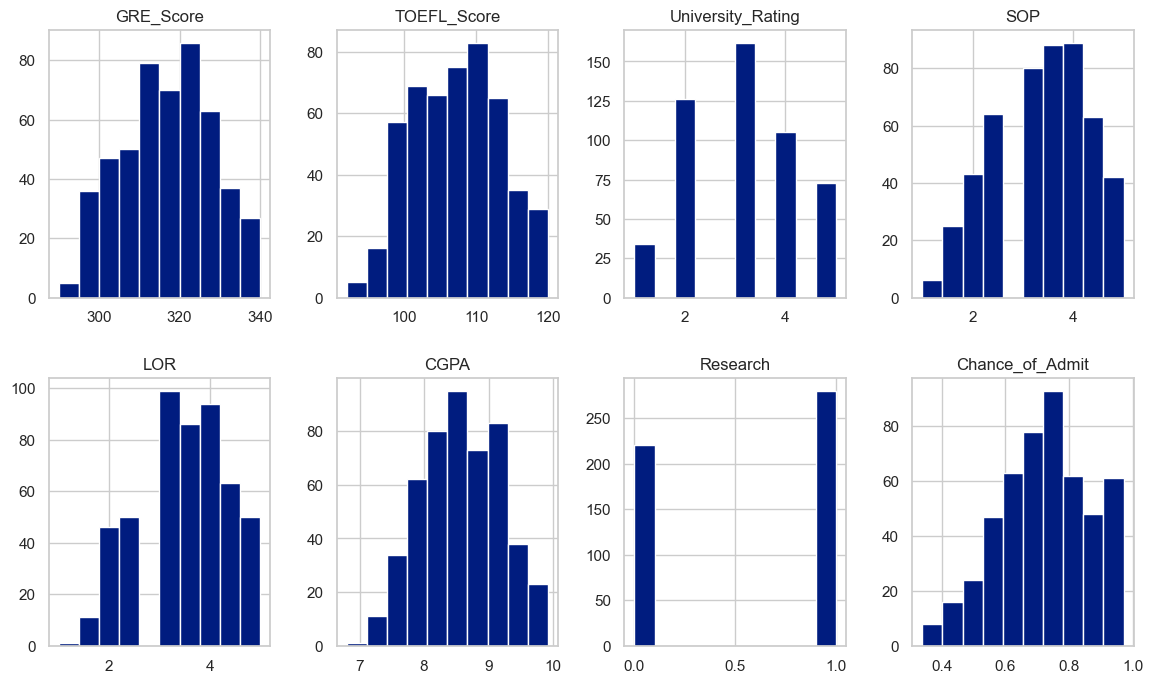

In [109]:
# 각 특징에 대한 히스토그램으로 데이터 시각화
data_frame.hist(figsize=(14, 8), bins=10, grid=True, layout=(2, 4))

In [110]:
# 모델 학습에서 사용하기 위해 DataFrame에서 target 변수 제거하는 코드
input_data_frame = data_frame.drop(['Chance_of_Admit'], axis=1)

input_data_frame.head(10)

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0
5,330,115,5,4.5,3.0,9.34,1
6,321,109,3,3.0,4.0,8.20,1
7,308,101,2,3.0,4.0,7.90,0
8,302,102,1,2.0,1.5,8.00,0
9,323,108,3,3.5,3.0,8.60,0


In [111]:
# 모델 학습에서 사용하기 위해 DataFrame에서 target 변수만 남기는 코드
target_column = data_frame['Chance_of_Admit'] # series 타입으로 반환
target_column = pd.DataFrame(target_column) 

target_column.head(10)

,Chance_of_Admit
0,0.92
1,0.76
2,0.72
3,0.80
4,0.65
5,0.90
6,0.75
7,0.68
8,0.50
9,0.45


In [112]:
# input_data_frame의 크기 출력
input_data_frame.shape

(500, 7)

In [113]:
# 데이터셋 train data와 test data로 나누는 코드
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
        train_test_split(input_data_frame, target_column, test_size=0.2, random_state=RANDOM_SEED)

# 4개의 집합의 크기를 출력하는 코드
print(f"{x_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_train.shape=}")
print(f"{y_test.shape=}")

x_train.shape=(400, 7)
x_test.shape=(100, 7)
y_train.shape=(400, 1)
y_test.shape=(100, 1)


데이터셋의 크기가 500개로 작기 때문에 Validation data를 지정하여 성능을 검증하지 않음<br>
대신 Cross Validation(교차 검증) 방식을 사용하여, 성능을 검증하기로 함

<h2>3. 모델 정의 및 학습</h2><br>

In [114]:
# XGBoost 알고리즘을 사용하는 회귀 모델 라이브러리를 불러온다
import xgboost as xgb

In [115]:
# DMatrix로 데이터를 변환(XGBoost 라이브러리에서 사용하는 데이터 타입)
dtrain = xgb.DMatrix(x_train, label=y_train)

# 파라미터 설정
params = {
    'objective': 'reg:squarederror',  # 회귀 목적 함수
    'learning_rate': 0.1,            # 학습률
    'max_depth': 5,                  # 트리 최대 깊이
    'random_state': RANDOM_SEED,     # 랜덤 시드
    'verbosity': 1                   # 로그 출력 수준
}

# 교차검증 수행
cv_results = xgb.cv(
    params=params,                  # XGBoost 파라미터
    dtrain=dtrain,                  # 학습 데이터
    num_boost_round=100,            # 부스팅 라운드 수
    nfold=5,                        # 5-Fold 교차검증
    metrics='rmse',                 # 평가 지표 (Root Mean Squared Error)
    early_stopping_rounds=10,       # 성능 개선 없을 시 10번 후 조기 종료
    verbose_eval=True               # 학습 로그 출력
)

# 최적 부스팅 라운드와 최적 성능 출력
print(f"최고의 RMSE: {cv_results['test-rmse-mean'].min():.4f}")
print(f"최선의 라운드: {cv_results['test-rmse-mean'].idxmin()}")

[0]	train-rmse:0.13130+0.00192	test-rmse:0.13217+0.00827
[1]	train-rmse:0.12082+0.00186	test-rmse:0.12290+0.00824
[2]	train-rmse:0.11144+0.00182	test-rmse:0.11472+0.00846
[3]	train-rmse:0.10305+0.00181	test-rmse:0.10765+0.00830
[4]	train-rmse:0.09555+0.00177	test-rmse:0.10162+0.00862
[5]	train-rmse:0.08887+0.00175	test-rmse:0.09631+0.00846
[6]	train-rmse:0.08290+0.00176	test-rmse:0.09154+0.00855
[7]	train-rmse:0.07758+0.00174	test-rmse:0.08766+0.00855
[8]	train-rmse:0.07286+0.00180	test-rmse:0.08412+0.00868
[9]	train-rmse:0.06860+0.00181	test-rmse:0.08111+0.00876
[10]	train-rmse:0.06484+0.00186	test-rmse:0.07854+0.00894
[11]	train-rmse:0.06145+0.00183	test-rmse:0.07646+0.00892
[12]	train-rmse:0.05843+0.00196	test-rmse:0.07453+0.00890
[13]	train-rmse:0.05580+0.00202	test-rmse:0.07314+0.00881
[14]	train-rmse:0.05346+0.00204	test-rmse:0.07199+0.00870
[15]	train-rmse:0.05137+0.00207	test-rmse:0.07081+0.00887
[16]	train-rmse:0.04950+0.00221	test-rmse:0.07001+0.00887
[17]	train-rmse:0.04773+

In [116]:
# 최적 부스팅 라운드 수
best_boost_rounds = cv_results['test-rmse-mean'].idxmin()

# 최적 부스팅 라운드로 모델 학습
model = xgb.XGBRegressor(
    n_estimators=best_boost_rounds,
    learning_rate=0.1,
    max_depth=5,
    objective='reg:squarederror',
    random_state=RANDOM_SEED,
    verbosity=2
)

# 모델 학습
model.fit(x_train, y_train)

# 테스트 데이터 예측 및 평가
from sklearn.metrics import mean_squared_error

y_prediction = model.predict(x_test)
mse = mean_squared_error(y_test, y_prediction)
print(f"{mse=:.5f}")

mse=0.00399


Validation Data를 사용하는 모델

In [117]:
# 데이터셋 train data와 test data로 나누는 코드
x_train2, x_test2, y_train2, y_test2 = \
    train_test_split(input_data_frame, target_column, test_size=0.2, random_state=RANDOM_SEED)

# Train 데이터를 다시 Train과 Validation으로 나눔
# 0.25 x 0.8 = 0.2 (Validation은 전체의 20%))
x_train2, x_val, y_train2, y_val = \
    train_test_split(x_train2, y_train2, test_size=0.25, random_state=RANDOM_SEED)

# 각 데이터 크기 출력
print(f"{x_train2.shape=}")
print(f"{x_val.shape=}")
print(f"{x_test2.shape=}")
print(f"{y_train2.shape=}")
print(f"{y_val.shape=}")
print(f"{y_test2.shape=}")

x_train2.shape=(300, 7)
x_val.shape=(100, 7)
x_test2.shape=(100, 7)
y_train2.shape=(300, 1)
y_val.shape=(100, 1)
y_test2.shape=(100, 1)


In [118]:
# XGBoost 알고리즘을 사용하는 회귀 모델2을 정의하는 코드

model2 = xgb.XGBRegressor(
    n_estimators=100, # 부스팅 라운드 수
    learning_rate=0.1, # 학습률
    max_depth=5, # 트리의 최대 깊이
    objective='reg:squarederror',  # 회귀 문제의 목적 함수
    random_state = RANDOM_SEED, # 랜덤 시드 지정
    verbosity=2, # 학습 과정에서 로그 출력 정도 지정
    eval_metric='rmse',  # 평가 지표 설정
    early_stopping_rounds=10,  # 10회 동안 성능 개선이 없으면 학습 종료
)

# xgboost 모델 정보 출력하는 코드
model2.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': 10,
 'enable_categorical': False,
 'eval_metric': 'rmse',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 10,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 2}

In [119]:
# 모델2 학습시키는 코드 (Validation 데이터 포함)
model2.fit(
    x_train2, y_train2,
    eval_set=[(x_val, y_val)],  # 검증 데이터 추가
    verbose=True               # 학습 로그 출력
)

[0]	validation_0-rmse:0.13167
[1]	validation_0-rmse:0.12330
[2]	validation_0-rmse:0.11626
[3]	validation_0-rmse:0.11010
[4]	validation_0-rmse:0.10483
[5]	validation_0-rmse:0.10019
[6]	validation_0-rmse:0.09646
[7]	validation_0-rmse:0.09316
[8]	validation_0-rmse:0.09024
[9]	validation_0-rmse:0.08797
[10]	validation_0-rmse:0.08571
[11]	validation_0-rmse:0.08402
[12]	validation_0-rmse:0.08242
[13]	validation_0-rmse:0.08136
[14]	validation_0-rmse:0.08031
[15]	validation_0-rmse:0.07959
[16]	validation_0-rmse:0.07877
[17]	validation_0-rmse:0.07840
[18]	validation_0-rmse:0.07774
[19]	validation_0-rmse:0.07724
[20]	validation_0-rmse:0.07712
[21]	validation_0-rmse:0.07680
[22]	validation_0-rmse:0.07658
[23]	validation_0-rmse:0.07609
[24]	validation_0-rmse:0.07600
[25]	validation_0-rmse:0.07570
[26]	validation_0-rmse:0.07536
[27]	validation_0-rmse:0.07523
[28]	validation_0-rmse:0.07519
[29]	validation_0-rmse:0.07512
[30]	validation_0-rmse:0.07513
[31]	validation_0-rmse:0.07514
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [120]:
# 최적 라운드 확인 (model2)
print(f"{model2.best_iteration=}")

# 최적 라운드로 테스트 데이터 평가
y_prediction2 = model2.predict(x_test2)
mse2 = mean_squared_error(y_test2, y_prediction2)
print(f"{mse2=:.5f}")

model2.best_iteration=35
mse2=0.00407


<h2>4. 성능 비교</h2><br>

In [121]:
# MSE 수치 비교
print(f"Using Cross Validation {mse=:.5f}")
print(f"Using Validation Data {mse2=:.5f}")

Using Cross Validation mse=0.00399
Using Validation Data mse2=0.00407
